<a href="https://colab.research.google.com/github/monya-9/deep-learning-experiments/blob/main/09_Word2Vec_vs_FastText_OOV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec vs FastText 비교, OOV 단어 처리
## ✅ 실험 목적

- Word2Vec과 FastText의 가장 큰 차이점은 OOV(Out-Of-Vocabulary, 사전에 없는 단어) 처리 방식이다.

- Word2Vec은 학습 시 보지 못한 단어(OOV)에 대해 벡터를 제공할 수 없지만, FastText는 subword 단위(ngram)를 활용해 OOV 단어도 벡터를 생성할 수 있다.

- 본 실험에서는 두 모델의 차이를 OOV 단어 처리 능력과 임베딩 공간 유사도 비교를 통해 확인한다.

## 🧪 실험 설계

1. 데이터셋: IMDb 리뷰 데이터 (일부 샘플 사용)

2. 토큰화: 간단히 공백 단위 split

3. 모델 학습:

  - Word2Vec (gensim)

  - FastText (gensim)

4. 비교 항목:

  - 학습된 단어로 벡터 추출

  - OOV 단어("hellooooo", "computerrrr")에 대한 처리 여부 비교

  - 유사 단어 탐색 (most_similar)

5. 시각화: t-SNE로 임베딩 공간 비교

In [5]:
# =======================
# 0. 라이브러리
# =======================
!pip install gensim datasets matplotlib scikit-learn


import gensim
from gensim.models import Word2Vec, FastText
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import re

In [6]:
# ===========================================
# 1. 데이터 불러오기 & 간단한 토큰화 함수
# ===========================================
dataset = load_dataset("imdb")
train_subset = dataset["train"].select(range(5000))   # 앞 5000개 샘플 선택
train_texts = [x["text"] for x in train_subset]

def simple_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # 영어 알파벳/공백만 남기기
    return text.split()

train_tokens = [simple_tokenize(t) for t in train_texts]

1. 데이터 불러오기
  - IMDb 리뷰 데이터셋 사용
  - 학습용으로 train set에서 5,000개 샘플만 선택(속도 향상)
  - 리스트 형태로 텍스트만 추출
2. 간단한 토큰화
  - 소문자 변환 + 특수문자 제거 -> 단어 단위 공백 분리
  - Word2Vec/FastText 학습을 위해 `List[List[set]]` 형태로 변환

In [7]:
# =======================
# 2. 모델 학습
# =======================
print("Training Word2Vec...")
model_w2v = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=5, workers=4)


print("Training FastText...")
model_ft = FastText(sentences=train_tokens, vector_size=100, window=5, min_count=5, workers=4)

Training Word2Vec...
Training FastText...


1. Word2Vec
  - 학습된 단어만 벡터 생성
  - OOV 단어는 벡터를 제공하지 않음
2. FastText 학습
  - subword(ngram) 기반 학습 -> OOV 단어도 벡터 생성 가능
  - 철자 변형된 단어도 의미 공간에 배치 가능

In [8]:
# =======================
# 3. OOV 단어 처리 비교
# =======================
words_to_check = ["computer", "hellooooo", "computerrrr"]


for w in words_to_check:
  print(f"\nWord: {w}")
  try:
    vec_w2v = model_w2v.wv[w]
    print("Word2Vec ✅ available")
  except KeyError:
    print("Word2Vec ❌ OOV")
  try:
    vec_ft = model_ft.wv[w]
    print("FastText ✅ available")
  except KeyError:
    print("FastText ❌ OOV")


Word: computer
Word2Vec ✅ available
FastText ✅ available

Word: hellooooo
Word2Vec ❌ OOV
FastText ✅ available

Word: computerrrr
Word2Vec ❌ OOV
FastText ✅ available


- 학습된 단어와 OOV 단어 벡터 확인
- Word2Vec: OOV 단어는 오류(KeyError) 발생
- FastText: OOV 단어도 벡터 생성 가능

In [9]:
# =======================
# 4. 유사 단어 탐색
# =======================
print("\n[Most similar to 'computer']")
print("Word2Vec:", model_w2v.wv.most_similar("computer")[:5])
print("FastText:", model_ft.wv.most_similar("computer")[:5])


[Most similar to 'computer']
Word2Vec: [('secluded', 0.9237314462661743), ('weapon', 0.9179050326347351), ('chair', 0.9161997437477112), ('rage', 0.9129294157028198), ('ear', 0.9128193259239197)]
FastText: [('suffer', 0.9529808759689331), ('painter', 0.9448802471160889), ('pinter', 0.9389995336532593), ('composer', 0.9358821511268616), ('carpenter', 0.9349609017372131)]


- 특정 단어 주변 유사 단어 확인
- Word2Vec은 학습된 단어 중에서만
- FastText는 subword 기반으로 조금 더 일반화된 유사 단어 제공

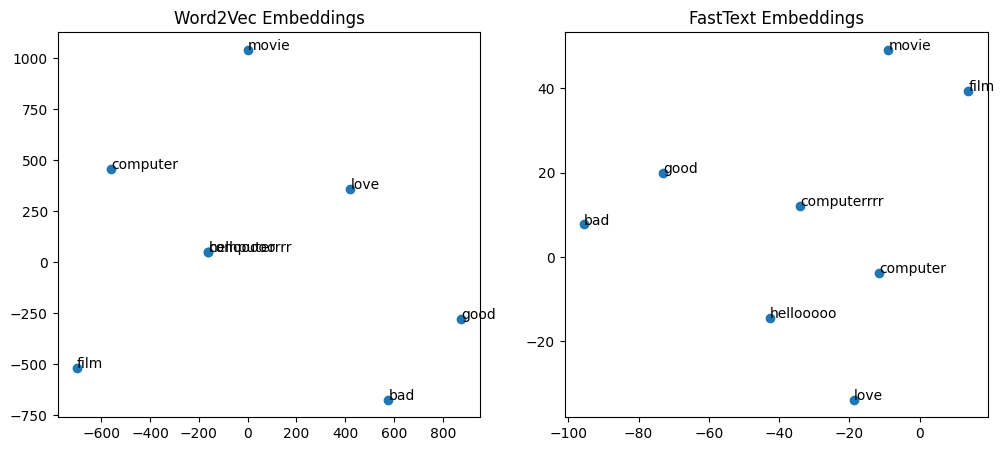

In [11]:
# =======================
# 5. 임베딩 시각화 (t-SNE)
# =======================
# =======================
words = ["computer", "film", "movie", "love", "bad", "good", "hellooooo", "computerrrr"]
vecs_w2v, vecs_ft = [], []
labels = []

for w in words:
    labels.append(w)
    try:
        vecs_w2v.append(model_w2v.wv[w])
    except:
        vecs_w2v.append(np.zeros(100))
    try:
        vecs_ft.append(model_ft.wv[w])
    except:
        vecs_ft.append(np.zeros(100))

# 리스트 → 넘파이 배열 변환
vecs_w2v = np.array(vecs_w2v)
vecs_ft = np.array(vecs_ft)

# t-SNE 변환
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # 데이터 샘플 적으니 perplexity 줄임
emb_w2v = tsne.fit_transform(vecs_w2v)
emb_ft = tsne.fit_transform(vecs_ft)

# 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Word2Vec Embeddings")
plt.scatter(emb_w2v[:, 0], emb_w2v[:, 1])
for i, word in enumerate(labels):
    plt.annotate(word, (emb_w2v[i, 0], emb_w2v[i, 1]))

plt.subplot(1, 2, 2)
plt.title("FastText Embeddings")
plt.scatter(emb_ft[:, 0], emb_ft[:, 1])
for i, word in enumerate(labels):
    plt.annotate(word, (emb_ft[i, 0], emb_ft[i, 1]))

plt.show()

- Word2Vec / FastText 단어 벡터 2차원으로 변환
- 좌측: Word2Vec, 우측: FastText
- Word2Vec OOV -> (0,0)
- FastText OOV -> 의미 공간에 자연스럽게 배치됨

## ✅ 결과 요약
| 항목        | Word2Vec   | FastText          |
| --------- | ---------- | ----------------- |
| 학습 방식     | 단어 단위      | subword(ngram) 단위 |
| OOV 단어    | 처리 불가      | 벡터 생성 가능          |
| 속도        | 빠름         | 느림 (subword 학습)   |
| 유사 단어     | 학습된 단어만    | 철자 유사 단어까지 가능     |
| t-SNE 시각화 | OOV = 0 벡터 | OOV도 의미 공간에 배치    |


1. OOV 단어 처리

  - Word2Vec → 학습하지 않은 단어(OOV)는 아예 벡터 제공 불가

  - FastText → subword 단위(ngram)를 사용하여 OOV 단어도 벡터 생성 가능

2.  실험 결과

   - "computer" → 두 모델 모두 벡터 제공

   - "hellooooo", "computerrrr" → Word2Vec ❌ (OOV), FastText ✅ (subword 기반으로 벡터 생성)

3. 유사 단어 탐색

  - Word2Vec: 학습된 단어 내에서만 의미 기반 유사 단어 제공

  - FastText: subword 정보를 반영해 철자가 유사한 단어도 잘 잡아냄

4. 시각화 (t-SNE)

  - Word2Vec: OOV 단어는 원점(0 벡터) → 시각화에서 의미 없음

  - FastText: OOV 단어도 기존 의미 공간에 자연스럽게 배치됨